In [1]:
import dgl
import dgl.function as fn
import torch
import pandas as pd
import os
import numpy as np

c:\Users\Wen2Tee5\Desktop\Postgraduate\torchPlayGround\torchEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
y_train = np.load('./R8/y_train.npy')
y_test = np.load('./R8/y_test.npy')
y_train = torch.tensor(y_train, dtype=torch.int64)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [3]:
print(y_train)
print(y_test)

tensor([0, 1, 0,  ..., 0, 7, 3])
tensor([2, 4, 3,  ..., 5, 1, 3])


In [4]:
data, _ = dgl.load_graphs('./R8/Transductive.bin')

In [5]:
he : dgl.DGLHeteroGraph = data[0]

In [6]:
DOC = 'doc'
WORD = 'word'
IN  = 'in'
OCCUR = 'occur'
PRESERVE = 'preserve'
DOC_PRESERVE = (DOC, PRESERVE, DOC)
DOC_CONTAIN = (WORD, IN, DOC)
WORD_OCCUR = (WORD, OCCUR, WORD)
# DIC_OFFSET = 2

In [7]:
he.nodes[DOC].data['train_mask'] == 1

tensor([ True,  True,  True,  ..., False, False, False])

In [8]:
class TEMPGCN(torch.nn.Module):

    def __init__(self, g : dgl.DGLHeteroGraph, in_feat, h_feat, num_class) -> None:
        super(TEMPGCN, self).__init__()
        self.embed = torch.nn.Embedding(g.num_nodes(ntype = WORD), in_feat, padding_idx=0)
        self.dropout = torch.nn.Dropout(p = 0)
        self.linear1 = torch.nn.Linear(in_feat, h_feat)
        self.linear2 = torch.nn.Linear(h_feat, h_feat // 2)
        self.linear3 = torch.nn.Linear(h_feat // 2, num_class)

    def forward(self, g : dgl.DGLHeteroGraph):
        with g.local_scope():
            he.update_all(message_func=fn.u_mul_e('x','w', 'm'), reduce_func=fn.sum('m', 'h'), etype=WORD_OCCUR)
            h = g.nodes[WORD].data['h']
            h = torch.nn.functional.relu(self.dropout(self.linear1(h)))
            g.nodes[WORD].data['h'] = h
            he.update_all(message_func=fn.u_mul_e('h', 'w', 'm'), reduce_func=fn.sum('m', 'h'), etype=DOC_CONTAIN)
            h = g.nodes[DOC].data['h']
            h = torch.nn.functional.relu(self.dropout(self.linear2(h)))
            h = self.linear3(h)
        return h


In [9]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
model = TEMPGCN(he, 300, 64, 8).to(DEVICE)
he = he.to(DEVICE)
y_train = y_train.to(DEVICE)
y_test = y_test.to(DEVICE)

In [11]:
he.nodes[WORD].data['x'] = model.embed.weight

In [12]:
train_mask = he.nodes[DOC].data['train_mask'] == 1
test_mask = he.nodes[DOC].data['train_mask'] == 0

In [13]:
opti = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = torch.nn.CrossEntropyLoss()
train_losses = []
test_losses = []
train_accs = []
test_accs = []

In [14]:
for epoch in range(300):
    opti.zero_grad()
    pred = model(he)
    loss = loss_fn(pred[train_mask], y_train)
    loss.backward()
    opti.step()
    train_losses.append(loss.item())
    with torch.no_grad():
        loss = loss_fn(pred[test_mask], y_test)
        test_losses.append(loss.item())
        train_accs.append(((pred[train_mask].argmax(1)==y_train).sum().type(torch.float32) / len(y_train)).item())
        test_accs.append(((pred[test_mask].argmax(1)==y_test).sum().type(torch.float32) / len(y_test)).item())

In [15]:
import matplotlib.pyplot as plt

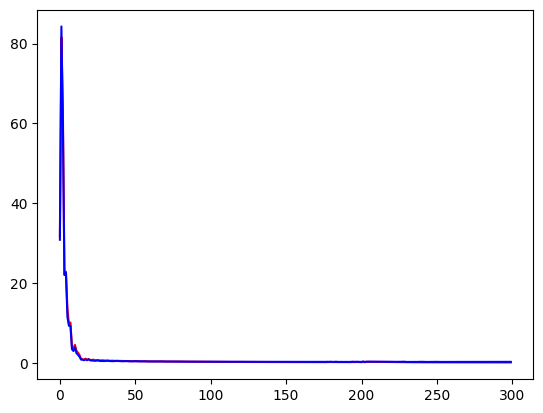

In [16]:

plt.plot(train_losses, color = 'r')
plt.plot(test_losses, color = 'b')
plt.show()

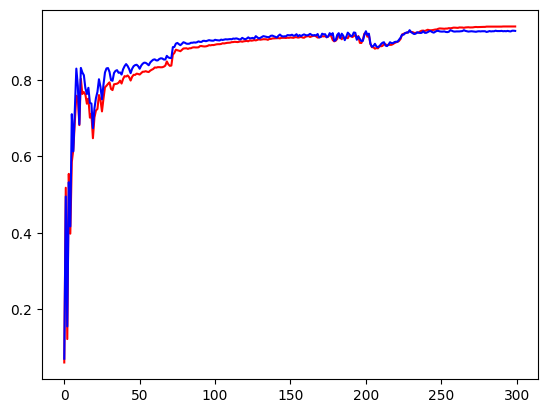

In [17]:
plt.plot(train_accs, color ='r')
plt.plot(test_accs, color ='b')
plt.show()

In [18]:
model.eval()
with torch.no_grad():
    pred = model(he)
    print(f'Test Acc is {(pred[test_mask].argmax(1)==y_test).sum().type(torch.float32) / len(y_test)}')
    print(f'Train Acc is {(pred[train_mask].argmax(1)==y_train).sum().type(torch.float32) / len(y_train)}')

Test Acc is 0.9282777905464172
Train Acc is 0.9398359060287476
